## 0. Imports

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
import pandas as pd
import os
from tensorflow.keras import layers
import keras
from keras import layers

## 1. Setup

2023-07-28 19:50:05.175149: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


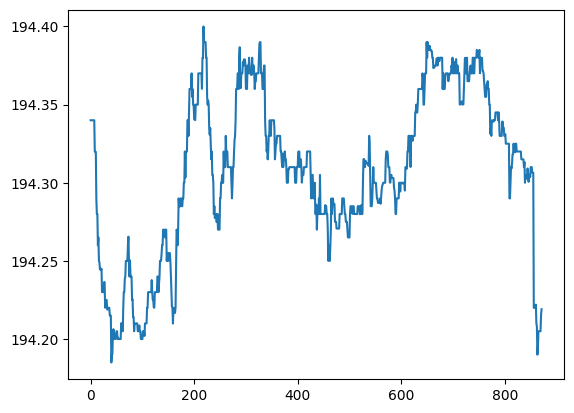

/var/folders/m4/_31v_sh92fq9fbbzdm6h266w0000gn/T/ipykernel_30140/842112328.py:36: RuntimeWarning: divide by zero encountered in divide
  raw_data /= std
/Users/ryanhermes/opt/anaconda3/envs/td-bot/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


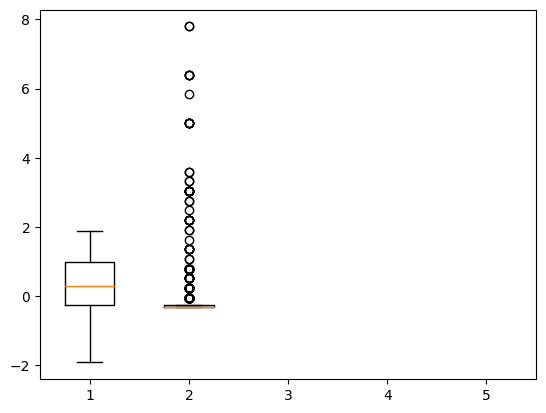

In [1]:
with open(f"resources/shortdata.csv", 'r') as file: data = file.read()

# Prepare data
header = data.split("\n")[0].split(",")
lines = data.split("\n")[1:]

underlying = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    underlying[i] = values[0]
    raw_data[i, :] = values[:]

plt.plot(range(len(underlying)), underlying)
plt.show()

# Split data
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = int(0.25 * len(raw_data))

# Normalize data
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

# Plot data
plt.boxplot(raw_data)
plt.show()

## 2. Prepare data for training & testing

Data: The dataset you are working with

Targets: What you want the model to try and predict

Sampling rate: Data points per unit of time

Sequence length: # of previous time steps used as inputs to predict next step

Shuffle: Randomly shuffle the data during training to introduce randomness

Batch size: Number of samples in each batch of the dataset (computational speed vs cpu load)

Start index: Starting index of the dataset

End index: Ending index of the dataset

Delay: Gap between end of sequence and target

In [2]:
batch_size = 100
sampling_rate = 1
sequence_length = 100
delay = 3

train_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=underlying[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=underlying[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=underlying[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (100, 100, 5)
targets shape: (100,)


2023-07-28 19:50:09.110649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [436]
	 [[{{node Placeholder/_20}}]]
2023-07-28 19:50:09.111555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [337]
	 [[{{node Placeholder/_8}}]]


## 3. A Dropout-Regularized LSTM Model

In [5]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("financeLSTM.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks) 

# Access the completed model
model = keras.models.load_model("./models/financeLSTM.keras")

# Plot the training and validation MAE
test_mae = history.history["mae"]
val_mae = history.history["val_mae"]
epochs = range(1, len(test_mae) + 1)

plt.figure()
plt.plot(epochs, test_mae, "r", label="Training MAE")
plt.plot(epochs, val_mae, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Epoch 1/10
4/4 [==============================] - 3s 142ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/10
4/4 [==============================] - 0s 87ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/10
4/4 [==============================] - 0s 81ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/10
4/4 [==============================] - 0s 58ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/10
4/4 [==============================] - 0s 51ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/10
4/4 [==============================] - 0s 73ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/10
4/4 [==============================] - 0s 78ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/10
4/4 [==============================] - 0s 78ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/10
4/4 [==============================] - 0s 78ms/step 

OSError: Unable to open file (file signature not found)

## 4. Test the Model

2023-07-28 19:36:56.518789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [116]
	 [[{{node Placeholder/_8}}]]
2023-07-28 19:36:56.519823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [215,5]
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - 0s 10ms/step - loss: nan - mae: nan
Test Loss: nan, Test MAE: nan
2/2 [==============================] - 0s 7ms/step


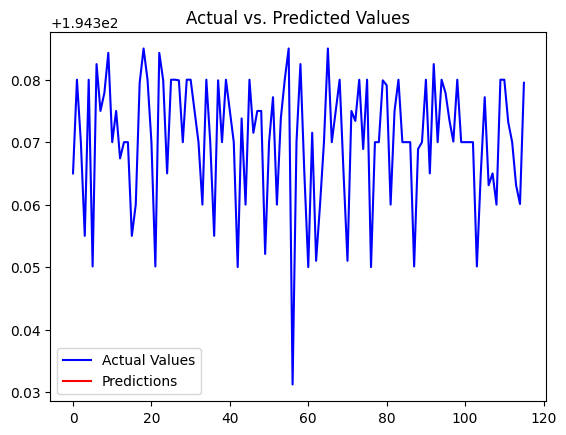

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_mae = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Make predictions on the test dataset
test_predictions = model.predict(test_dataset)

# Flatten the test targets and predictions if necessary
test_targets = np.concatenate([y for x, y in test_dataset], axis=0).flatten()
test_predictions = test_predictions.flatten()

# Plot the predictions against the actual values
plt.figure()
plt.plot(test_targets, "b", label="Actual Values")
plt.plot(test_predictions, "r", label="Predictions")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()